In [5]:
import pandas as pd
import numpy as np
import os
from scipy.stats import rankdata
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import shutil
from scipy.stats import hypergeom, norm

In [6]:
# Constants to define thresholds and limits for pathway analysis
MIN_GENE_PER_PATHWAY = 20  # Minimum number of genes per pathway to consider
MAX_GENE_PER_PATHWAY = 200  # Maximum number of genes per pathway to consider
FDR_THRESHOLD = 0.05  # False Discovery Rate threshold for significance
JAC_THRESHOLD = 0.2  # Jaccard index threshold for comparing sets
P_VALUE_THRESHOLD = 0.05  # P-value threshold for statistical significance

# Base directory for project files
root_path = '/mnt/c/Users/pickh/PycharmProjects/Yair_propagation'

# Directory for storing output files
output_path = os.path.join(root_path, 'Outputs')

# Configuration for the experiment
Experiment_name = 'Parkinson'  # Name of the experiment, used for labeling outputs
data_folder_name = 'Data'  # Folder name where data files are stored
species = 'H_sapiens'  # Species identifier, used to fetch species-specific files
genes_info_filename = 'H_sapiens.gene_info'  # File containing gene information
pathway_filename = 'pathways'  # File containing pathway data

# Constructing paths for data directories
data_dir = os.path.join(root_path, data_folder_name)
input_dir = os.path.join(root_path, 'Inputs', 'experiments_data', Experiment_name)

# Full paths to the genes and pathways files
genes_info_file_path = os.path.join(data_dir, species, 'genes_names', genes_info_filename)
pathway_file_dir = os.path.join(data_dir, species, 'pathways', pathway_filename)

temp_output_folder = os.path.join(root_path, 'Outputs', 'Temp')
# Ensure output directories exist
os.makedirs(temp_output_folder, exist_ok=True)
filtered_genes = set()

In [7]:
def load_pathways_genes():
    """
    Load pathway data from a file and parse it into a dictionary with pathway names as keys and lists of gene IDs as values.

    Returns:
    dict: A dictionary mapping pathway names to lists of gene IDs.
    """
    pathways = {}
    # Open the file containing pathway data
    with open(pathway_file_dir, 'r') as file:
        for line in file:
            # Process each line, normalize case, and split by tab
            parts = line.strip().upper().split('\t')
            # Skip lines that don't have at least 3 parts or where the second part isn't a digit
            if len(parts) < 3 or not parts[1].isdigit():
                continue

            # Parse pathway name and expected size
            pathway_name, pathway_size = parts[0], int(parts[1])

            # Collect gene IDs ensuring they are numeric and don't exceed the pathway size
            genes = [int(gene) for gene in parts[2].split()[:pathway_size] if gene.isdigit()]
            pathways[pathway_name] = genes
    return pathways

def get_scores(test_name):
    """
    Retrieve scores for a given test by reading a corresponding CSV file.

    Parameters:
    - test_name (str): The name of the test for which scores are needed.

    Returns:
    tuple: A tuple containing a dictionary of scores and a dictionary of P-values, both indexed by 'GeneID'.
    """
    # Construct the file path for the raw scores
    raw_scores_file_path = os.path.join(input_dir, f'{test_name}.csv')

    try:
        # Load scores from the specified file
        raw_data = pd.read_csv(raw_scores_file_path, usecols=['GeneID', 'Score', 'P-value'])
        # Sort data by GeneID for consistent access
        raw_data.sort_values(by='GeneID', inplace=True)

        # Transform raw data into a dictionary for quick lookup
        scores_dict = raw_data.set_index('GeneID')[['Score', 'P-value']].to_dict()
        return scores_dict

    except FileNotFoundError:
        print(f"File not found: {raw_scores_file_path}")
        return {}, {}
    except Exception as e:
        print(f"An error occurred: {e}")
        return {}, {}

In [8]:
def hypergeometric_sf(x, M, N, n):
    """
    Calculate the survival function (complement of the CDF) for the hypergeometric distribution.

    Parameters:
    - x (int): The number of successful draws.
    - M (int): The total size of the population.
    - N (int): The number of success states in the population.
    - n (int): The number of draws.

    Returns:
    float: The survival function probability.
    """
    # Calculate the survival function using hypergeometric distribution
    probability = hypergeom.sf(x - 1, M, N, n)
    return probability

In [9]:
# def bh_correction(p_values):
#     """
#     Perform Benjamini-Hochberg correction for multiple hypothesis testing on a list of P-values.
#
#     Parameters:
#     - p_values (list of float): The original P-values from multiple hypotheses tests.
#
#     Returns:
#     list of float: Adjusted P-values after applying Benjamini-Hochberg correction.
#     """
#     # Calculate ranks for the P-values, both in 'max' and 'ordinal' method
#     p_vals_max_rank = rankdata(p_values, 'max') - 1
#     p_vals_ordinal_rank = rankdata(p_values, 'ordinal') - 1
#
#     # Initialize an array to store sorted indices based on rank
#     p_values_sorted_indices = np.zeros_like(p_vals_max_rank)
#     p_values_sorted_indices[p_vals_ordinal_rank] = np.arange(len(p_vals_ordinal_rank))
#
#     # Adjust the P-values using the BH correction formula
#     adjusted_p_values = p_values * (len(p_values) / (p_vals_max_rank + 1))
#     adjusted_p_values_by_rank = adjusted_p_values[p_values_sorted_indices]
#
#     # Order the adjusted P-values and apply cumulative minimum to meet BH conditions
#     p_values_ordered = np.minimum(adjusted_p_values_by_rank,
#                                   np.minimum.accumulate(adjusted_p_values_by_rank[::-1])[::-1])
#     final_adjusted_p_values = p_values_ordered[p_vals_max_rank]
#
#     return final_adjusted_p_values

In [10]:
def perform_statist(test_name):
    """
    Perform statistical analysis to determine significant pathways based on gene scores and P-values.

    Parameters:
    - test_name (str): The name of the test to retrieve scores and P-values for genes.

    Returns:
    tuple: A dictionary of significant pathways with their genes and adjusted P-values,
           and a dictionary of scores for all genes.
    """
    # Retrieve scores and P-values for the specified test
    scores = get_scores(test_name)

    # Identify genes with P-values below the significance threshold
    significant_p_vals = {gene_id: p_value for gene_id, p_value in scores['P-value'].items() if p_value < 0.05}

    # Retrieve keys (gene IDs) with scores
    scores_keys = set(scores['Score'].keys())

    # Filter pathways by those having gene counts within the specified range and that intersect with scored genes
    pathways_with_many_genes = {
        pathway: set(genes).intersection(scores_keys)
        for pathway, genes in genes_by_pathway.items()
        if MIN_GENE_PER_PATHWAY <= len(set(genes).intersection(scores_keys)) <= MAX_GENE_PER_PATHWAY
    }

    # Populate a set with all genes from the filtered pathways
    for genes in pathways_with_many_genes.values():
        filtered_genes.update(genes)

    # Total number of scored genes
    M = len(scores_keys)
    # Number of genes with significant P-values
    n = len(significant_p_vals)

    # Prepare lists to hold the hypergeometric P-values and corresponding pathway names
    hypergeom_p_values = []
    pathway_names = []

    # Calculate hypergeometric P-values for each pathway with enough genes
    for pathway_name, pathway_genes in pathways_with_many_genes.items():
        N = len(pathway_genes)  # Number of genes in the current pathway
        x = len(set(pathway_genes).intersection(significant_p_vals.keys()))  # Enriched genes in the pathway
        # Apply hypergeometric test; if fewer than 5 enriched genes, assign a P-value of 1 (non-significant)
        pval = hypergeometric_sf(x, M, N, n) if x >= 5 else 1
        hypergeom_p_values.append(pval)
        pathway_names.append(pathway_name)

    # Identify pathways with significant hypergeometric P-values
    significant_pathways = [
        pathway for i, pathway in enumerate(pathway_names) if hypergeom_p_values[i] < 0.05
    ]

    # Perform the Kolmogorov-Smirnov test to compare distributions of scores between pathway genes and background
    ks_p_values = []
    for pathway in significant_pathways:
        genes = pathways_with_many_genes[pathway]
        pathway_scores = [scores['Score'][gene_id] for gene_id in genes if gene_id in scores['Score']]
        background_genes = scores_keys - genes
        background_scores = [scores['Score'][gene_id] for gene_id in background_genes]
        ks_p_values.append(kolmogorov_smirnov_test(pathway_scores, background_scores))

    # # Apply Benjamini-Hochberg correction to the KS P-values
    # adjusted_p_values = bh_correction(np.array(ks_p_values))
    #use fdr correction
    adjusted_p_values = multipletests(ks_p_values, method='fdr_bh')[1]

    # Filter significant pathways based on adjusted KS P-values
    ks_significant_pathways_with_genes = {
        pathway: (pathways_with_many_genes[pathway], adjusted_p_values[i])
        for i, pathway in enumerate(significant_pathways)
        if adjusted_p_values[i] < 0.05
    }

    # Return the dictionary of significant pathways with gene lists and adjusted P-values, and the original scores
    return ks_significant_pathways_with_genes, scores

In [11]:
def perform_statist_mann_whitney(passed_ks_pathway_dict, scores):
    """
    Perform the Mann-Whitney U test on pathways that passed the initial KS test,
    followed by Benjamini-Hochberg correction and filtering based on the Jaccard index.

    Parameters:
    - passed_ks_pathway_dict (dict): Dictionary of pathways and their genes that passed the KS test.
    - scores (dict): Dictionary containing scores for genes.

    Returns:
    dict: Filtered pathways after applying statistical tests and corrections.
    """
    mw_p_values = []  # List to store Mann-Whitney p-values
    significant_pathways_with_genes = {}

    # Use filtered_genes for ranking and background scores
    filtered_scores = [scores['Score'][gene_id] for gene_id in filtered_genes]

    # Rank the scores only for the filtered genes and reverse the ranks
    ranks = rankdata(filtered_scores)
    scores_rank = {
        gene_id: rank for gene_id, rank in zip(filtered_genes, ranks)
    }

    # Iterate over pathways that passed the KS test to perform the Mann-Whitney U test
    for pathway, genes_info in passed_ks_pathway_dict.items():
        pathway_genes = set(genes_info[0])
        pathway_scores = [scores['Score'][gene_id] for gene_id in pathway_genes]
        background_genes = filtered_genes - pathway_genes
        background_scores = [scores['Score'][gene_id] for gene_id in background_genes]

        pathway_ranks = [scores_rank[gene_id] for gene_id in pathway_genes]
        background_ranks = [scores_rank[gene_id] for gene_id in background_genes]

        # Compute the Mann-Whitney U test p-value using scores
        mw_pval = wilcoxon_rank_sums_test(pathway_scores, background_scores)
        _, rmw_pval = compute_mw_python(pathway_ranks, background_ranks)
        mw_p_values.append(mw_pval)

    # Apply Benjamini-Hochberg correction to adjust the p-values
    # adjusted_mw_p_values = bh_correction(np.array(mw_p_values))
    adjusted_mw_p_values = multipletests(mw_p_values, method='fdr_bh')[1]

    # Collect significant pathways after adjustment
    filtered_pathways = []
    for i, (pathway, genes) in enumerate(passed_ks_pathway_dict.items()):
        if adjusted_mw_p_values[i] < 0.05:  # Threshold for significance
            filtered_pathways.append({
                'Pathway': pathway,
                'Adjusted_p_value': adjusted_mw_p_values[i],
                'Genes': genes[0]
            })

    # Convert the list of filtered pathways to a DataFrame and sort by p-value
    pathways_df = pd.DataFrame(filtered_pathways)
    pathways_df.sort_values(by='Adjusted_p_value', inplace=True)

    # Filter out pathways with high overlap using the Jaccard index
    final_filtered_pathways = {}
    for i, row in pathways_df.iterrows():
        current_genes = set(row['Genes'])
        if not any(jaccard_index(current_genes, set(filtered_row['Genes'])) > JAC_THRESHOLD
                   for filtered_row in final_filtered_pathways.values()):
            final_filtered_pathways[row['Pathway']] = row

    return final_filtered_pathways

In [12]:
def jaccard_index(set1, set2):
    """
    Calculate the Jaccard index, a measure of the similarity between two sets.

    Parameters:
    - set1 (set): First set of items.
    - set2 (set): Second set of items.

    Returns:
    float: The Jaccard index ranging from 0 (no overlap) to 1 (complete overlap).
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0  # Avoid division by zero

In [13]:
def kolmogorov_smirnov_test(experiment_scores, control_scores):
    """
    Perform the Kolmogorov-Smirnov test to compare two samples.

    Parameters:
    - experiment_scores (list): Scores from the experimental group.
    - control_scores (list): Scores from the control group.

    Returns:
    float: The P-value from the KS test indicating statistical difference.
    """
    # Convert lists to numpy arrays for efficient operations
    experiment_scores = np.sort(experiment_scores)
    control_scores = np.sort(control_scores)

    # Calculate the length of each sample
    en1 = len(experiment_scores)
    en2 = len(control_scores)

    # Combine the scores and compute cumulative distribution functions
    data_all = np.concatenate([experiment_scores, control_scores])
    cdf_experiment = np.searchsorted(experiment_scores, data_all, side='right') / en1
    cdf_control = np.searchsorted(control_scores, data_all, side='right') / en2

    # Compute the maximum distance between the two CDFs
    D = np.max(np.abs(cdf_experiment - cdf_control))

    # Calculate the KS statistic
    en = np.sqrt(en1 * en2 / (en1 + en2))
    p_value = ks((en + 0.12 + 0.11 / en) * D)

    return p_value


def ks(alam):
    """
    Compute the Kolmogorov-Smirnov probability given a lambda value.

    Parameters:
    - alam (float): Lambda value for the KS statistic.

    Returns:
    float: The probability associated with the KS statistic.
    """
    EPS1 = 1e-6  # Precision for the convergence of term's absolute value
    EPS2 = 1e-10  # Precision for the convergence of the sum's relative value
    a2 = -2.0 * alam ** 2  # Adjust lambda for exponential calculation
    fac = 2.0
    sum = 0.0
    termbf = 0.0

    # Sum the series until convergence criteria are met
    for j in range(1, 101):
        term = fac * np.exp(a2 * j ** 2)  # Calculate term of the series
        sum += term  # Add to sum

        # Check for convergence
        if np.abs(term) <= EPS1 * termbf or np.abs(term) <= EPS2 * sum:
            return sum

        fac = -fac  # Alternate the sign
        termbf = np.abs(term)  # Update the term before flag

    # Return 1.0 if the series does not converge within 100 terms
    return 1.0

In [14]:
def wilcoxon_rank_sums_test(experiment_scores, control_scores, alternative='two-sided'):
    """
    Perform the Wilcoxon rank-sum test to compare two independent samples.

    Parameters:
    - experiment_scores (list): Scores from the experimental group.
    - control_scores (list): Scores from the control group.
    - alternative (str): Defines the alternative hypothesis ('two-sided', 'less', 'greater').

    Returns:
    float: The P-value from the Wilcoxon rank-sum test.
    """
    from scipy.stats import ranksums
    p_vals = ranksums(experiment_scores, control_scores, alternative=alternative).pvalue
    return p_vals


def compute_mw_python(experiment_ranks, control_ranks):
    """
    Compute the Mann-Whitney U test manually using rank sums to determine the statistical difference
    between two independent samples.

    Parameters:
    - experiment_ranks (list): Ranks of the experimental group.
    - control_ranks (list): Ranks of the control group.
    Returns:
    tuple: The Mann-Whitney U statistic and the corresponding p-value.
    """

    # Calculate the sum of ranks for each group
    R1 = np.sum(experiment_ranks)
    R2 = np.sum(control_ranks)

    # Number of observations in each group
    n1 = len(experiment_ranks)
    n2 = len(control_ranks)

    # Compute the Mann-Whitney U statistics for both groups
    U1 = R1 - n1 * (n1 + 1) / 2  # U statistic for the experimental group
    U2 = R2 - n2 * (n2 + 1) / 2  # U statistic for the control group

    # Use the smaller U statistic as the test statistic
    U = min(U1, U2)

    # Calculate the mean and standard deviation for the U distribution under H0 (null hypothesis)
    mean_U = n1 * n2 / 2
    std_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)

    # Calculate the Z-score associated with U statistic
    Z = (U - mean_U) / std_U

    # Calculate the two-tailed p-value from the Z-score
    p_value = 2 * norm.cdf(-np.abs(Z))  # Two-tailed test

    return U, p_value

In [15]:
def print_enriched_pathways_to_file(filtered_pathways, output_folder, test_name, threshold=0.05):
    """
    Write pathways with adjusted P-values below a specified threshold to a file.

    Parameters:
    - filtered_pathways (dict): Dictionary containing pathways and their details (including adjusted P-values).
    - output_folder (str): Directory where the output file will be saved.
    - test_name (str): Name of the test, used to name the output file.
    - threshold (float, optional): P-value threshold for pathways to be considered significant. Defaults to 0.05.
    """
    output_file_path = os.path.join(output_folder, f'{test_name}.txt')
    significant_count = 0  # Counter for significant pathways

    with open(output_file_path, 'w') as file:
        for pathway, details in filtered_pathways.items():
            p_value = details.get('Adjusted_p_value')
            if p_value is not None and p_value < threshold:
                file.write(f"{pathway} {p_value:.5f}\n")  # Format p-value to 5 decimal places
                significant_count += 1

    print(f"Total significant pathways written: {significant_count}")

In [16]:
def read_scores(file_name):
    """
    Read scores from a file into a dictionary.

    Parameters:
    - file_name (str): Path to the file containing the scores.

    Returns:
    dict: A dictionary mapping pathways to their scores.
    """
    try:
        scores = pd.read_csv(file_name, sep=' ', header=None, names=['Pathway', 'Score'], index_col='Pathway')
        return scores['Score'].to_dict()
    except FileNotFoundError:
        print(f"File not found: {file_name}")
        return {}
    except Exception as e:
        print(f"Error reading scores from {file_name}: {e}")
        return {}
    
    
def read_pathways(file_name):
    """
    Reads pathways from a file into a dictionary mapping each pathway to a list of gene IDs.

    Parameters:
    - file_name (str): Path to the file containing the pathways.

    Returns:
    dict: A dictionary mapping pathway names to lists of gene IDs.
    """
    try:
        with open(file_name, 'r') as file:
            return {line.split()[0]: [int(gene) for gene in line.split()[2:]] for line in file if line.strip()}
    except FileNotFoundError:
        print(f"File not found: {file_name}")
        return {}
    except Exception as e:
        print(f"Error reading pathways from {file_name}: {e}")
        return {}

In [17]:
def process_condition(condition_file, experiment_file, pathways_file):
    """
    Processes experimental data to determine the enrichment and trends of pathways based on specified conditions.

    Parameters:
    - condition_file (str): Path to the file containing score conditions.
    - experiment_file (str): Path to the file containing experimental data.
    - pathways_file (str): Path to the file containing pathways data.

    Returns:
    dict: A dictionary containing scores, enriched pathway genes, and mean scores for pathways under the given condition.
    """
    # Read scores for the condition, mapping pathways to their scores
    enriched_pathway_dict = read_scores(condition_file)

    # Load experiment data and filter out entries where the score is zero
    condition_data_df = pd.read_csv(experiment_file)
    experiment_data_filtered_df = condition_data_df[condition_data_df['Score'] != 0]

    # Extract the condition name from the file name
    condition_name = os.path.basename(condition_file).split('.')[-2]

    # Load pathway data mapping pathway names to lists of gene IDs
    homo_sapien_pathway_dict = read_pathways(pathways_file)

    # Dictionary to store enriched pathway genes
    enriched_pathway_genes = {}

    # Loop through each pathway
    for pathway in all_pathways:
        # Initialize a dictionary for the pathway under the current condition
        all_pathways[pathway][condition_name] = {}

        # List of genes associated with the current pathway
        pathway_genes = homo_sapien_pathway_dict[pathway]

        # Filter the experiment data to only include genes that are part of the current pathway
        pathway_filtered_genes = experiment_data_filtered_df[experiment_data_filtered_df['GeneID'].isin(pathway_genes)]

        # Store details of filtered genes in a dictionary
        enriched_pathway_genes[pathway] = pathway_filtered_genes.set_index('GeneID')[['Symbol', 'Score', 'P-value']].to_dict(
            orient='index')

        # Filter to find significant genes based on the P-value threshold
        significant_genes = {gene_id: gene_details for gene_id, gene_details in
                             enriched_pathway_genes[pathway].items() if
                             gene_details['P-value'] <= P_VALUE_THRESHOLD}

        # Calculate the mean score of significant genes or set to 0 if none are significant
        mean_score = np.mean(
            [gene_details['Score'] for gene_details in significant_genes.values()]) if significant_genes else 0

        # Store the mean score and significant genes for the pathway under the condition
        all_pathways[pathway][condition_name]['Mean'] = mean_score
        all_pathways[pathway][condition_name]['significant_genes'] = significant_genes

        # Check if the pathway is in the enriched pathway dictionary to assign a P-value and trend
        if pathway in enriched_pathway_dict:
            all_pathways[pathway][condition_name]['P-value'] = enriched_pathway_dict[pathway]
            all_pathways[pathway][condition_name]['Trend'] = "Up*" if mean_score > 0 else "Down*"
        else:
            all_pathways[pathway][condition_name]['P-value'] = 1  # Default P-value if not in enriched dictionary
            all_pathways[pathway][condition_name]['Trend'] = "Up" if mean_score > 0 else "Down"


In [18]:
def bold_keywords(text, keywords):
    """
    Returns text with specified keywords emboldened.

    Parameters:
    - text (str): The original text where keywords need to be bolded.
    - keywords (list of str): A list of words within the text that need to be bolded.

    Returns:
    str: The modified text with specified keywords in bold.
    """
    for keyword in keywords:
        if keyword in text:
            # Corrected to replace only the keyword in the text, not the entire text
            text = text.replace(keyword, f"**{keyword}**")
    return text

In [19]:
def print_aggregated_pathway_information(output_dir, experiment_name):
    """
    Print aggregated pathway information including P-values, trends, and significant genes
    for each pathway to a text file based on a given experiment.

    Parameters:
    - output_dir (str): Directory where the output text file will be saved.
    - experiment_name (str): Name of the experiment used to name the output file.
    """
    # Define the path for the output file
    file_path = os.path.join(output_dir, 'Text', f'{experiment_name}_aggregated.txt')

    # Create a list of (pathway, best_p_value) tuples
    pathways_p_values = []
    for pathway, conditions in all_pathways.items():
        # Find the minimum P-value for each pathway across all conditions
        best_p_value = min(condition_data['P-value'] for condition_data in conditions.values())
        pathways_p_values.append((pathway, best_p_value))

    # Sort pathways by the best (lowest) P-value
    pathways_sorted = sorted(pathways_p_values, key=lambda x: x[1])

    # Write to the output file
    with open(file_path, 'w') as file:
        for pathway, best_p_value in pathways_sorted:
            file.write(f"Pathway: {pathway} P-value: {best_p_value:.5f}\n")  # Print pathway and its best P-value

            # Aggregate and write trends for all conditions for the pathway
            trends = [f"{condition_name}: {all_pathways[pathway][condition_name]['Trend']}"
                      for condition_name in all_pathways[pathway]]
            file.write(f"Trends: {', '.join(trends)}\n")

            # Aggregate and write significant genes across all conditions
            file.write("Significant Genes:\n")
            gene_scores_across_conditions = {}
            for condition_name, condition_data in all_pathways[pathway].items():
                for gene_id, gene_info in condition_data.get('significant_genes', {}).items():
                    if gene_id not in gene_scores_across_conditions:
                        gene_scores_across_conditions[gene_id] = {'Symbol': gene_info['Symbol'], 'Scores': []}
                    gene_scores_across_conditions[gene_id]['Scores'].append(gene_info['Score'])

            # List each gene with its scores across conditions
            for gene_id, gene_data in gene_scores_across_conditions.items():
                scores_str = ', '.join(map(str, gene_data['Scores']))
                file.write(f"    {gene_data['Symbol']}: {scores_str}\n")

            file.write("\n")

In [20]:
def plot_pathways_mean_scores(output_dir, experiment_name):
    """
    Plots mean scores of pathways across different experimental conditions in a horizontal bar chart,
    highlighting significant differences.

    Parameters:
    - output_dir (str): The directory where the plot will be saved.
    - experiment_name (str): The name of the experiment to be used in naming the output file.
    """
    # Initialize dictionaries to store mean scores and p-values for each condition
    mean_scores_data = {}
    p_values_data = {}
    for pathway, conditions in all_pathways.items():
        for condition_name, condition_data in conditions.items():
            mean_scores_data.setdefault(condition_name, {})[pathway] = condition_data.get('Mean', 0)
            p_values_data.setdefault(condition_name, {})[pathway] = condition_data.get('P-value', 1)

    # Create DataFrames from the dictionaries
    data_df = pd.DataFrame(mean_scores_data)
    p_values_df = pd.DataFrame(p_values_data)

    # Create a large figure to accommodate the potentially large number of pathways
    plt.figure(figsize=(20, 60))  # This may need adjustment based on the actual data
    ax = plt.subplot(111)

    # Prepare data for plotting
    conditions = list(mean_scores_data.keys())
    total_pathways = data_df.index
    num_conditions = len(conditions)
    bar_height = 0.8 / num_conditions  # Calculate bar height based on the number of conditions
    positions = np.arange(len(total_pathways))

    # Generate a color map for the conditions
    colors = plt.cm.get_cmap('viridis', num_conditions)

    # Define keywords for bold formatting
    keywords = ['NEURO', 'SYNAP']

    # Plot each condition's mean scores for each pathway
    for i, condition in enumerate(conditions):
        mean_scores = data_df[condition].values
        p_values = p_values_df[condition].values

        # Plot bars with different styles based on p-value significance
        for j, (score, p_value) in enumerate(zip(mean_scores, p_values)):
            bar_style = {"color": "white", "edgecolor": colors(i), "hatch": "//"} if p_value > P_VALUE_THRESHOLD else {"color": colors(i)}
            ax.barh(positions[j] + bar_height * i, score, height=bar_height, **bar_style)

    # Set y-axis labels to be pathway names, replace underscores with spaces for readability
    ax.set_yticks(positions + bar_height * (num_conditions / 2) - bar_height / 2)
    formatted_pathways = [pathway.replace('_', ' ') for pathway in total_pathways]
    ax.set_yticklabels(formatted_pathways, fontsize=12)

    # Bold labels for specific keywords
    for i, label in enumerate(ax.get_yticklabels()):
        if any(keyword in label.get_text().upper() for keyword in keywords):
            label.set_fontweight('bold')

    # Label axes and set title
    ax.set_ylabel('Pathways', fontsize=16)
    ax.set_xlabel('Mean Scores', fontsize=16)
    ax.set_title('Pathway Mean Scores Across Different Conditions', fontsize=20)

    # Create a legend for the conditions
    plt.legend([plt.Rectangle((0,0),1,1, color=colors(i)) for i in range(num_conditions)], conditions, prop={'size': 14})

    # Adjust subplot layout to avoid clipping of tick-labels
    plt.subplots_adjust(left=0.4)

    # Save the figure to a PDF file in the specified output directory
    output_file_path = os.path.join(output_dir, 'Plots', f"{experiment_name}_pathway_scores.pdf")
    plt.savefig(output_file_path, format='pdf', bbox_inches='tight')
    plt.show()

In [21]:
# Load pathway genes data to map pathways to their respective genes
genes_by_pathway = load_pathways_genes()

# Define a list of tests to be processed
test_list = ['T_v_N', '10um_v_T', '500Nm_v_T']
for test_name in test_list:
    print(f"running enrichment on {test_name}")
    # Perform initial statistical enrichment test to identify significant pathways
    significant_pathways_with_genes, scores = perform_statist(test_name)
    # Further statistical test using Mann-Whitney U test
    filtered_pathways = perform_statist_mann_whitney(significant_pathways_with_genes, scores)
    # Output the enriched pathways to files
    print_enriched_pathways_to_file(filtered_pathways, temp_output_folder, test_name)

print("finished enrichment")

running enrichment on T_v_N
Total significant pathways written: 37
running enrichment on 10um_v_T
Total significant pathways written: 25
running enrichment on 500Nm_v_T
Total significant pathways written: 27
finished enrichment


In [22]:
# Define file paths for additional conditions
test_file_paths = [f'{input_dir}/T_v_N.csv', f'{input_dir}/10um_v_T.csv', f'{input_dir}/500Nm_v_T.csv']

# Extract the test names from the file paths to match them with condition files
test_names = [os.path.splitext(os.path.basename(path))[0] for path in test_file_paths]

# Get the list of condition files
condition_files_unsorted = [os.path.join(temp_output_folder, file) for file in os.listdir(temp_output_folder)]

# Sort condition_files based on the order of test_names
condition_files = sorted(condition_files_unsorted, key=lambda x: test_names.index(os.path.splitext(os.path.basename(x))[0]))


In [23]:
all_pathways = {}

# Load enriched pathways from files into a dictionary for further processing
for condition_file in condition_files:
    enriched_pathway_dict = read_scores(condition_file)
    condition_name = os.path.basename(condition_file).split('.')[-2]
    for pathway in enriched_pathway_dict.keys():
        if pathway not in all_pathways:
            all_pathways[pathway] = {}

# Process conditions and aggregate data
for condition_file, experiment_file in zip(condition_files, test_file_paths):
    process_condition(condition_file, experiment_file, pathway_file_dir)

/tmp/ipykernel_943/2887790660.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_conditions)


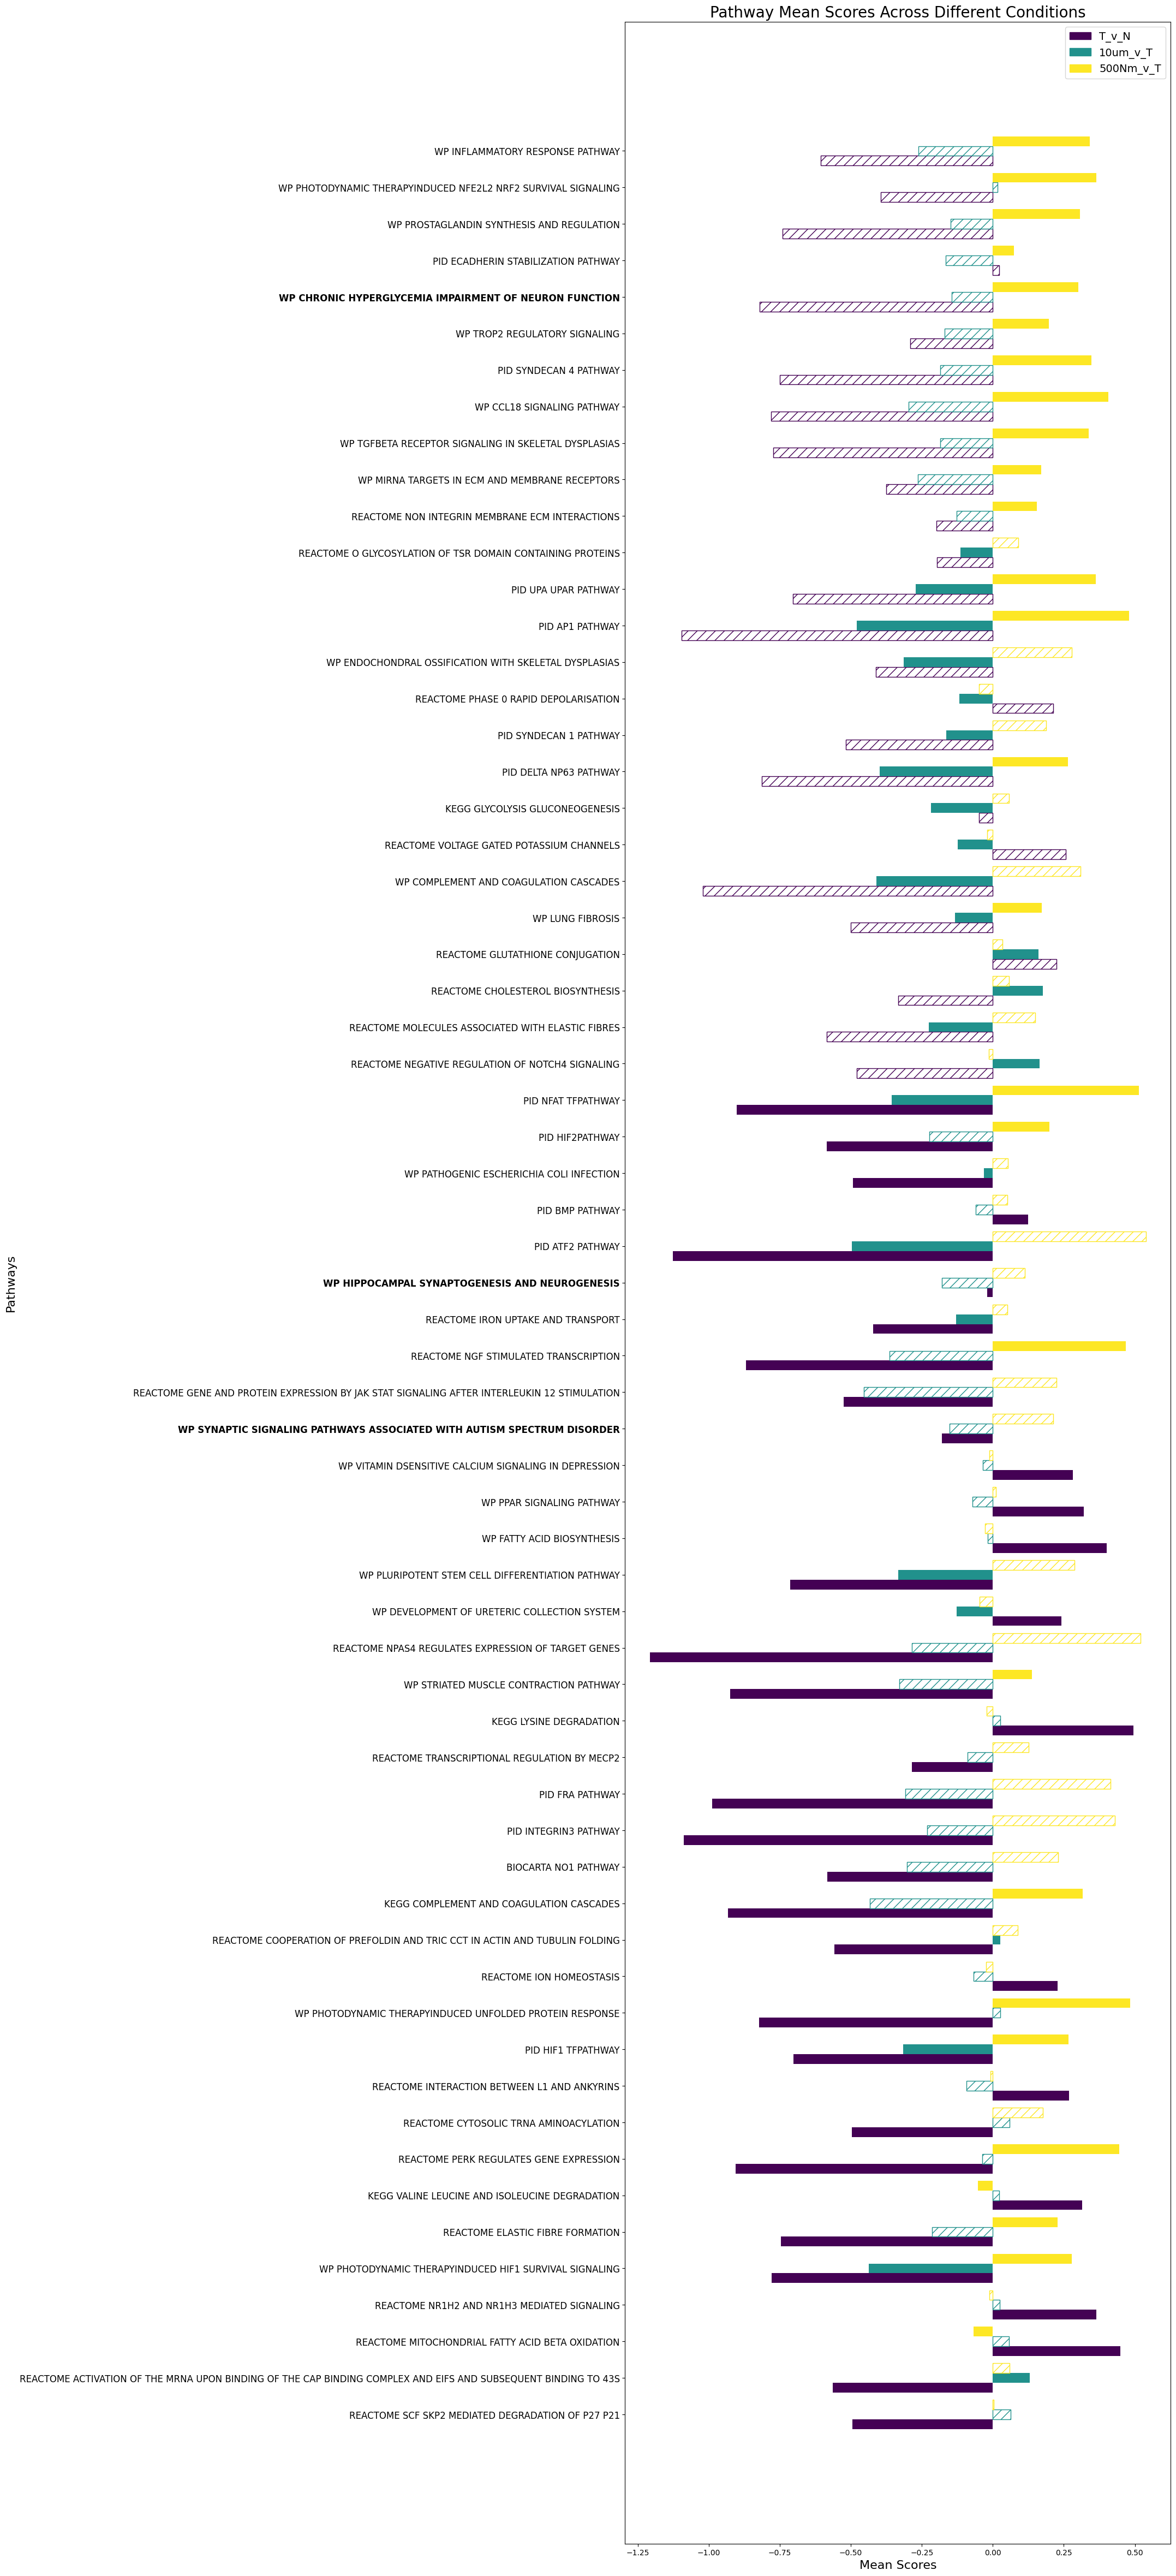

In [24]:
# Output aggregated pathway information to a text file
print_aggregated_pathway_information(output_path, Experiment_name)

# Visualize mean scores of pathways across all conditions
plot_pathways_mean_scores(output_path, Experiment_name)

In [25]:
# Clean up temporary output folder if it exists
if os.path.exists(temp_output_folder):
    shutil.rmtree(temp_output_folder)